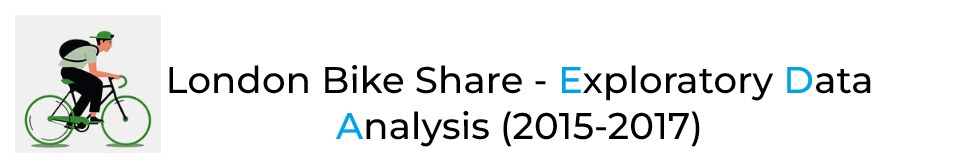

## Load dependencies and data from kaggle

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import scipy.stats as stats
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download latest version
path = kagglehub.dataset_download("hmavrodiev/london-bike-sharing-dataset")

print("Path to dataset files:", path)

100%|██████████| 165k/165k [00:00<00:00, 33.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/hmavrodiev/london-bike-sharing-dataset/versions/1


In [4]:
df = pd.read_csv(path + "/london_merged.csv")
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


## Data Overview

In [5]:
df.shape

(17414, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [7]:
# Check the Cardinality of each column
for col in df.columns:
  print(f'{col}: {df[col].nunique()}')


timestamp: 17414
cnt: 3781
t1: 73
t2: 82
hum: 143
wind_speed: 103
weather_code: 7
is_holiday: 2
is_weekend: 2
season: 4


## Data Cleaning

In [9]:
# Check for duplicates
df.duplicated().sum()

0

In [10]:
# Check for null values
df.isnull().sum().any()

False

In [11]:
# Do mappings for visualizations
df['season'] = df['season'].map({0:'spring', 1:'summer', 2:'fall', 3:'winter'})
df['is_holiday'] = df['is_holiday'].map({0:'no', 1:'yes'})
df['is_weekend'] = df['is_weekend'].map({0:'no', 1:'yes'})
df['weather_code'] = df['weather_code'].map({1:'clear', 2:'scattered clouds', 3:'broken clouds', 4:'cloudy', 7:'rain', 10:'thunderstorm', 26:'snowfall', 94:'freezing fog'})

In [12]:
# Update data types
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['weather_code'] = df['weather_code'].astype('str')
df['season'] = df['season'].astype('str')
df['is_holiday'] = df['is_holiday'].astype('str')
df['is_weekend'] = df['is_weekend'].astype('str')

In [13]:
# Change humidity values to percentages
df['humidity_perc'] = df['hum'] / 100
df.drop('hum', axis=1, inplace=True)

In [14]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create seperate 'date'  columns
df['date'] = pd.to_datetime(df['timestamp'].dt.date)

cols = df.columns.tolist()

# Move 'date' and 'time' to the first positions in df
cols = ['date'] +  [col for col in cols if col != 'date']
df = df[cols]

### Data to exported to Tableau

In [15]:
df_t = df.copy()

# Save data to excel file for Tableau
df_t.to_excel('Tableau_bike_sharing.xlsx', sheet_name='Source Data')

### Data to be exported to PostgreSQL

In [16]:
df_sql = df.copy()

# Export clean data to csv for import to postgresql
df_sql.to_csv('bike_sharing.csv', index=False)

## Exploratory Data Analysis

In [17]:
# Create new meaningful column names for visualizations
new_cols_dict = {
    'date': 'date',
    'timestamp':'timestamp',
    'cnt':'count',
    't1':'temp_real_C',
    't2':'temp_feels_like_C',
    'hum':'humidity_percent',
    'wind_speed':'wind_speed_kph',
    'weather_code':'weather',
    'is_holiday':'is_holiday',
    'is_weekend':'is_weekend',
    'season':'season'
}

# Rename columns
df.rename(columns=new_cols_dict, inplace=True)

### 🚴 Univariate Analysis

#### <font color='#051094'><u>Distribution of numerical variables</u></font>

*We will see how frequently each range of values within a specified variable occur and also observe the shape of the distributions.*

In [18]:
num_cols = df.select_dtypes(include='number').columns

In [19]:
df[num_cols].describe()

,count,temp_real_C,temp_feels_like_C,wind_speed_kph,humidity_perc
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,15.913063,0.723250
std,1085.108068,5.571818,6.615145,7.894570,0.143132
min,0.000000,-1.500000,-6.000000,0.000000,0.205000
25%,257.000000,8.000000,6.000000,10.000000,0.630000
50%,844.000000,12.500000,12.500000,15.000000,0.745000
75%,1671.750000,16.000000,16.000000,20.500000,0.830000
max,7860.000000,34.000000,34.000000,56.500000,1.000000


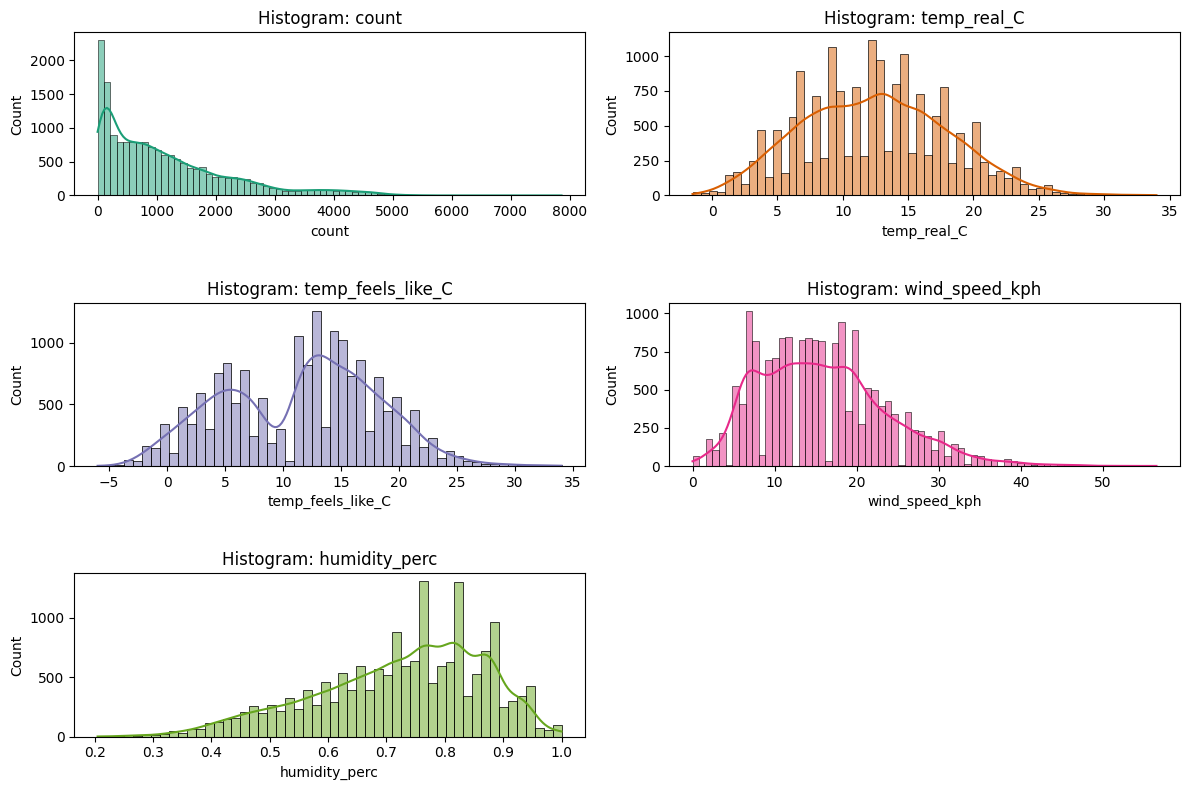

In [20]:
def create_histplot(data, columns):
  nrows= math.ceil(len(columns) /2)
  fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 8))
  colors = sns.color_palette('Dark2', n_colors=len(columns))

  for idx, col in enumerate(columns):
    ax = axes[idx // 2, idx % 2 ]
    color=colors[idx]
    sns.histplot(x=col, data=data, kde=True,ax=ax, color=color)
    ax.set_title(f'Histogram: {col}')
    ax.set_xlabel(col)
  # Remove empty subplots
  if len(columns) % 2 != 0:
    fig.delaxes(axes[-1, -1])
  plt.tight_layout(h_pad = 3.0)
  plt.show()


create_histplot(df, num_cols)

<font color='#0492c2'><b>OBSERVATIONS</b></font>

- Most of the number of bike rentals: **cnt** are concentrated on the lower end between 0 and 2000.

- Most common Actual temperatures : **t1** values fall between 5°C and 20°C.

- "Feels like" temperature : **t2** dataset shows significant variability and ranges mostly between 5°C and 15°C.

- There is a high concentration of humidity values : **hum** in the 60-90% range, with 80% being the most typical.

- 15km/h is the most frequently occuring wind speed.


#### <font color='#051094'><u> Distribution of the categorical variables</u></font>

*We will see how the data is spread across differnt categories within a specified variable.*

In [21]:
df1 = df.copy()
cat_cols = [col for col in df.select_dtypes(include='object').columns if col != 'time']

# Convert dtype to categorical for visualizations
for col in cat_cols:
  df1[col] = df1[col].astype('category')

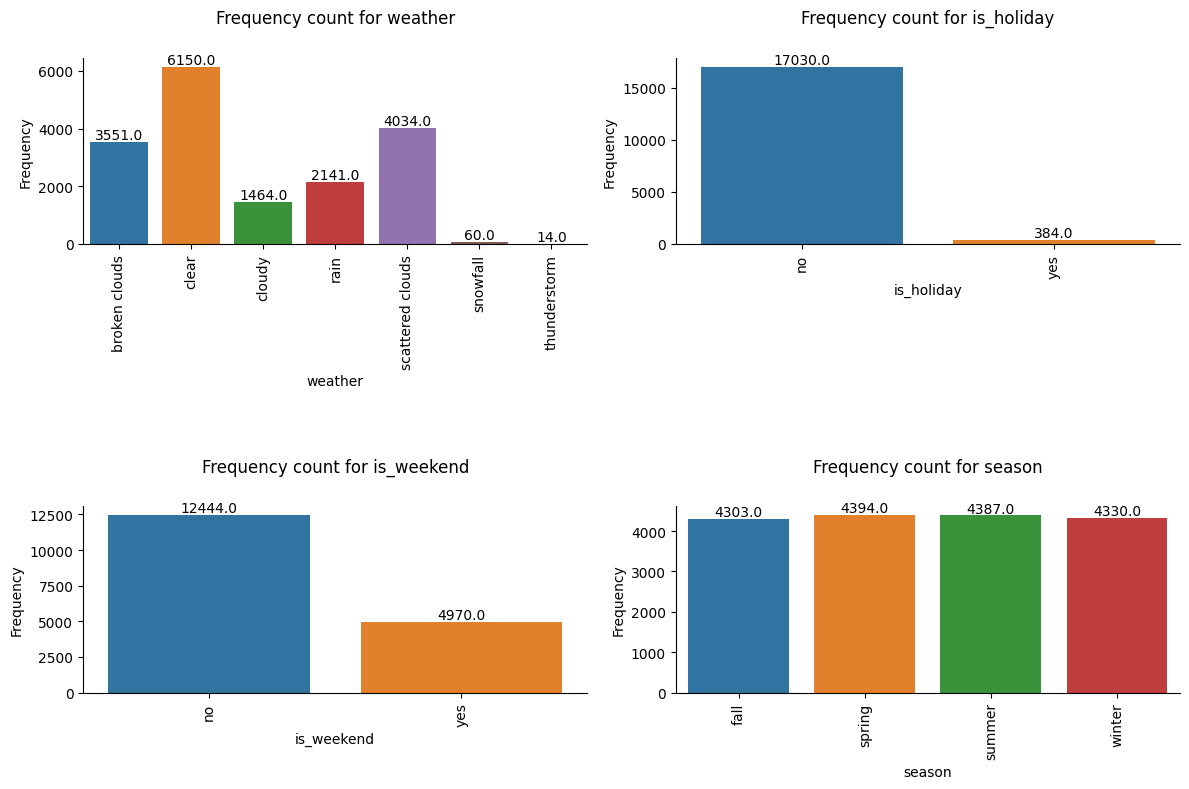

In [22]:
def create_countplot(data, columns):
  nrows= math.ceil(len(columns) /2)
  fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 8))

  for idx, col in enumerate(columns):
    ax = axes[idx // 2, idx % 2 ]
    sns.countplot(x=col, data=data, hue=col, ax=ax)

    # Display bar heights
    for p in ax.patches:
      ax.annotate(f'{p.get_height()}',
                  (p.get_x() + p.get_width() / 2. , p.get_height()),
                  ha='center', va='center',
                  xytext=(0, 5),
                  textcoords='offset points')
    ax.set_title(f'Frequency count for {col}', pad=25)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

    # Rotate x-tick labels
    plt.sca(ax)
    plt.xticks(rotation=90)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
  plt.tight_layout(h_pad = 5)
  plt.show()

create_countplot(df1, cat_cols)

<font color='#0492c2'><b>OBSERVATIONS</b></font>

- Clear weather  is the most preferred weahther condition for bike rentals, followed by scattered clouds and broken clouds. Rain is also relatively common, while people rarely rent bikes in  extreme weather conditions like thunderstorms and snow.
- Fewer people rent bikes on holidays when compared to non-holidays.
- There are more instances of bike rentals on weekdays compared to weekends.
- Bike-sharing is a popular and reliable mode of transportation in London, irrespective of seasonal changes.

### 🚴 Bivariate Analysis

####<font color='#051094'><u> Average bike sharing rides per day</u></font>

*We observe the average bike sharing rides per day which will help to identify high- and low-demand days.*

In [23]:
# Average bike sharing counts per day
avg_bike_rides_per_day = df.groupby(df['date'].dt.day_name())['count'].mean().sort_values(ascending=False).reset_index()
avg_bike_rides_per_day = avg_bike_rides_per_day.rename(columns={'date':'day', 'count':'avg_count'})
#avg_bike_rides_per_day

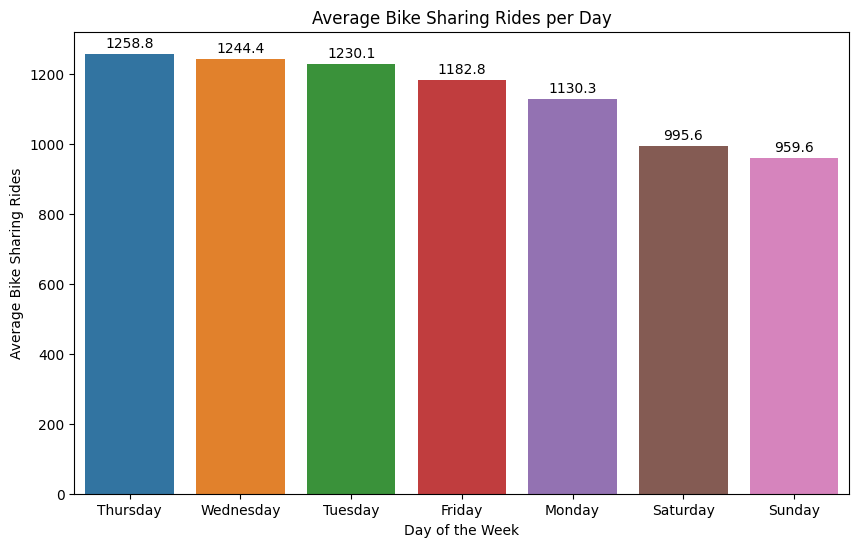

In [24]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='day', y='avg_count', data=avg_bike_rides_per_day, hue='day')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
                     (p.get_x() + p.get_width() / 2., p.get_height() + 10),  # Adjust the offset here
                     ha='center', va='bottom')
plt.title('Average Bike Sharing Rides per Day')
plt.xlabel('Day of the Week')
plt.ylabel('Average Bike Sharing Rides')
plt.show()

<font color='#0492c2'><b>OBSERVATIONS</b></font>

Thursday has the highest average number of bike rentals per day, followed closely by Wednesday. This suggests that mid-week days are the most popular for bike rentals.

❗**ACTIONS**

- Optimise bikes and staff to ensure availability on high-demand days.Plan maintenance or resource management on low-demand days. Adjust operations to meet demands efficiently.
- Expand targeted marketing efforts on specific days.Offer promotions or discounts during off-peak hours to boost usage when demand is lower.Launch marketing campaigns during peak hours to attract more users and increase ridership.

#### <font color='#051094'><u>Time of the day with the most bike sharing counts</u></font>

*We will analyze the number of bike shares at different hours of the day to establish usage patterns.*

In [25]:
# Extract hour from time
df['hour'] = df['timestamp'].dt.hour.astype('str')

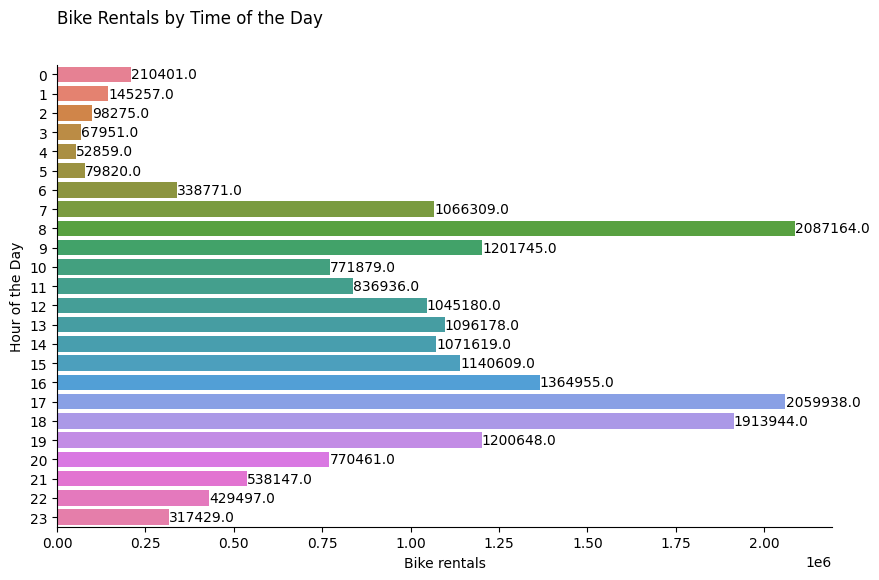

In [26]:
plt.figure(figsize=(10, 6))
# Create the horizontal bar plot with sum as estimator
ax = sns.barplot(data=df, y='hour', x='count', hue = 'hour',estimator=sum, errorbar=None)


# Add rotated count values on the bars with an offset
for p in ax.patches:
        ax.annotate(format(p.get_width(), '.1f'),  # Swap get_height() with get_width()
                (p.get_width() + 50, p.get_y() + p.get_height() / 2.),  # Adjust the offset here
                ha='left', va='center')

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Bike Rentals by Time of the Day', loc='left', pad=30)
plt.ylabel('Hour of the Day')
plt.xlabel('Bike rentals')

plt.show()

<font color='#0492c2'><b>OBSERVATIONS</b></font>

- The highest bike sharing counts are observed at 8 AM and 5 PM. These times correspond to the morning and evening commute periods.
- The lowest usage is observed during the early morning hours (1-4 AM) and late night hours (12-1 AM).

❗**ACTIONS**

Ensure bike availability and reliability during peak times to enhance user satisfaction and implement seamless experiences by reducing waiting times and making sure bikes are in good condition.


### 🚴 Multivariate Analysis



#### <font color='#051094'><u>How bike rentals vary with humidity levels across different seasons </u></font>

*We want to observe how bike rentals vary with humidity levels across different seasons, helping to identify peak seasons, forcast demand  and plan accordingly.*


In [27]:
# Create bins for humidity_percent
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']
df['humidity_bins'] = pd.cut(df['humidity_perc'] * 100, bins=bins, labels=labels, right=False)

# Group by humidity_bins and season, then count
count_by_humidity_and_season = df.groupby(['humidity_bins', 'season'], observed=True)['count'].sum().reset_index()
count_by_humidity_and_season.tail()

,humidity_bins,season,count
11,61-80%,winter,1809949
12,81-100%,fall,1457928
13,81-100%,spring,593613
14,81-100%,summer,729460
15,81-100%,winter,1358118


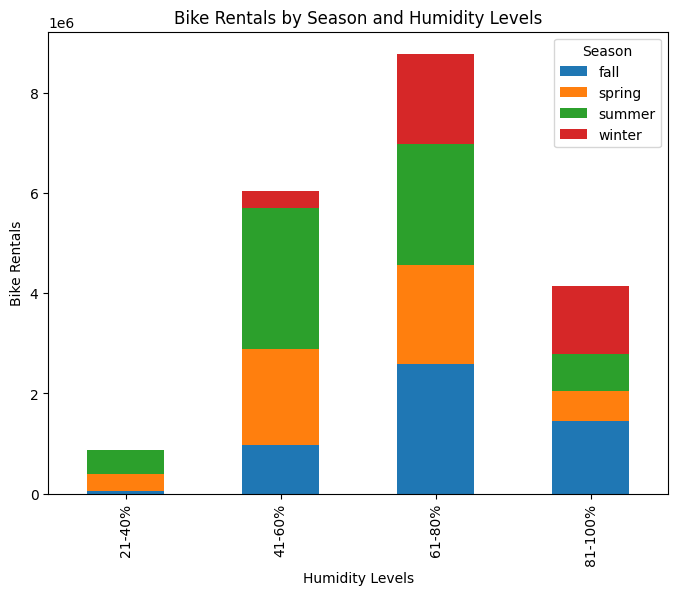

In [28]:
# Pivot the data for stacked bar plot
pivot_df = count_by_humidity_and_season.pivot(index='humidity_bins', columns='season', values='count').fillna(0)

# Create a stacked barplot
pivot_df.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Bike Rentals by Season and Humidity Levels')
plt.xlabel('Humidity Levels')
plt.ylabel('Bike Rentals')
plt.legend(title='Season')
plt.show()

<font color='#0492c2'><b>OBSERVATIONS</b></font>

- The optimal range of humidity levels for bike sharing is 61-80%.
- Lower humidity levels : 21-40% are less favorable for biking.
- High humidity does not significantly deter bike usage as indicated by the considerable rentals at humidy levels in the range of 81-100%.

- During the summer, there is a wide range of humidity levels, with the highest number of bike shares occurring, particularly in the 41-60% humidity range. Summer consistently sees higher bike rentals across all humidity levels.

❗**ACTIONS**

Develop strategies to encourage biking during less favorable conditions (e.g., low humidity) by offering promotions or incentives.

####<font color='#051094'><u> Hourly Weather conditions vs Bike Rentals</u></font>

*Let's examine the relationship between type of weather  and the  hour of the day. We can use a  heatmap to visually represent how time of day and weather interact and whether their combined effect influences rental patterns.**


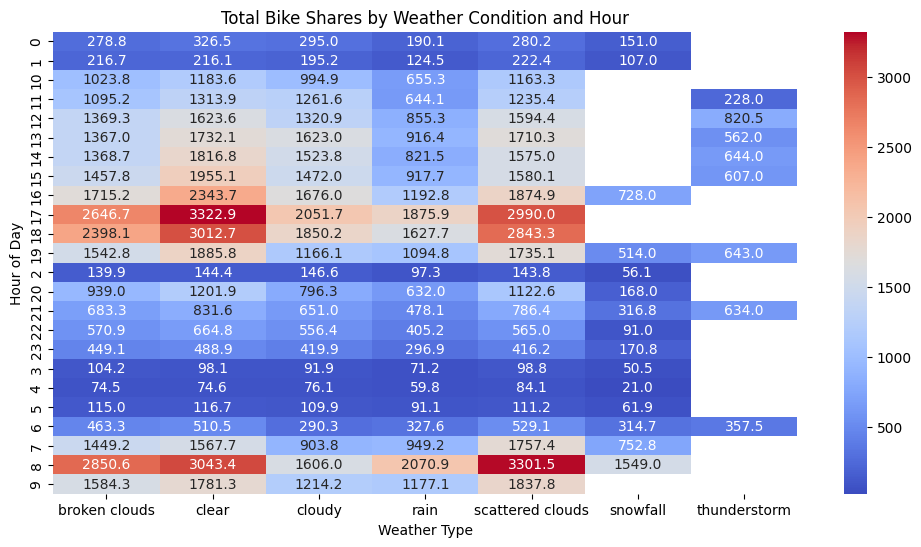

In [32]:
avg_bike_counts_by_weather_and_hr = df.groupby(['weather', 'hour'])['count'].mean().reset_index()
pivot_table = avg_bike_counts_by_weather_and_hr.pivot(index='hour', columns='weather', values='count')


plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Total Bike Shares by Weather Condition and Hour')
plt.ylabel('Hour of Day')
plt.xlabel('Weather Type')
plt.show()

<font color='#0492c2'><b>OBSERVATIONS</b></font>

The heatmap indicates that weather conditions are a key determinant in the decision to rent a bike.Clear weather and broken clouds are ideal for bike sharing, while rainy, snowy, and thunderstorm conditions discourage people from renting bikes.

Bike rentals are generally lower during the night, regardless of weather conditions.

❗**ACTIONS**

- Collect feedback from users about their experiences during different times of the day to identify areas for improvement.

- Use historical data to predict future demand patterns and adjust operations accordingly.

- Plan special promotions or events during times when bike usage is naturally higher (e.g., weekdays for commuters).

#### <font color='#051094'><u>Total Bike Rentals Against Temperature Over Time</u></font>

*We observe whether seasonal trends exist and whether there are correlations between the average temperature and total bike rentals for each day. This can  help to  optimize  operations, marketing strategies, and resource management to align with user behavior influenced by temperature changes.*

In [30]:
# Compute the daily rental
rental_summary = df.groupby('date').agg(total_rentals=('count', 'sum'), avg_temp=('temp_real_C', 'mean')).reset_index()

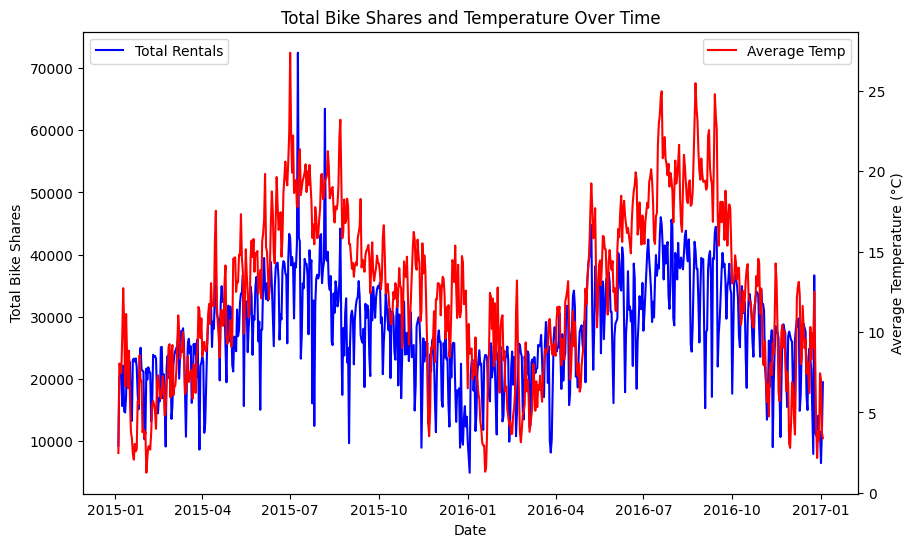

In [33]:
# Create the primary plot axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total rentals on the primary y-axis
sns.lineplot(data=rental_summary, x='date', y='total_rentals', color='b', label='Total Rentals', ax=ax1)

# Create the secondary y-axis
ax2 = ax1.twinx()

# Plot average temperature on the secondary y-axis
sns.lineplot(data=rental_summary, x='date', y='avg_temp', color='red', label='Average Temp', ax=ax2)

# Adding titles and labels
ax1.set_title('Total Bike Shares and Temperature Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Bike Shares')
ax2.set_ylabel('Average Temperature (°C)')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


<font color='#0492c2'><b>OBSERVATIONS</b></font>

- Bike rentals peak during the warmer months and decrease significantly during the colder months.
- There is a positive correlation between temperature and bike rentals. As temperatures rise , bike rentals increase and as temperatures fall bike rentals decrease.
- The pattern appears to follow yearly cycles, with similar peaks and troughs observed in the corresponding months each year.

❗**ACTIONS**

Schedule major maintenance and inventory checks during off-peak season to ensure maximum availability and efficiency during peak times.